In [8]:
%matplotlib inline

#System
import os
import shutil

#Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from skimage.io import imread, imshow, imsave

#Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from keras.layers import Dropout,BatchNormalization, Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger

#Preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence, to_categorical

#Models
from keras.applications.vgg16 import VGG16

#GPU
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 
K.set_session(sess)

#Seed
seed = 99
np.random.seed(seed)
random.seed(seed)

In [9]:
class_encoded = []
with open('static/class_encode.txt') as f:
    for line in f:
        line = line.strip()
        new_index, old_index_arr, class_name_arr = line.split(";")
        
        new_index = int(new_index)
        old_index_arr = list(map(int, old_index_arr.split("|")))
        class_name_arr = class_name_arr.split("|")
        class_encoded.append([new_index, old_index_arr, class_name_arr])

class_encoded

[[0, [0], ['-']],
 [1, [2977, 975, 446], ['wall', 'floor, flooring', 'ceiling']],
 [2,
  [470, 2678, 2271, 56, 2585, 180],
  ['chair', 'swivel chair', 'seat', 'armchair', 'stool', 'bench']],
 [3, [1734, 790], ['painting, picture', 'drawing']],
 [4,
  [349, 2328, 238, 2984, 2035],
  ['cabinet', 'shelf', 'bookcase', 'wardrobe, closet, press', 'rack']],
 [5,
  [3054, 211, 2421, 1746],
  ['windowpane, window',
   'blind, screen',
   'skylight, fanlight',
   'pane, pane of glass, window glass']],
 [6,
  [2683, 3086, 723, 570, 1373, 626, 593],
  ['table',
   'work surface',
   'desk',
   'coffee table, cocktail table',
   'kitchen island',
   'counter',
   'console table, console']],
 [7,
  [1450, 1394, 2242, 377, 2508, 375, 981, 1444, 372, 479],
  ['light, light source',
   'lamp',
   'sconce',
   'candlestick, candle holder',
   'spotlight, spot',
   'candle, taper, wax light',
   'fluorescent, fluorescent fixture',
   'light bulb, lightbulb, bulb, incandescent lamp, electric light, electr

In [10]:
def get_model(img_shape, num_classes):
    block0_input = Input(shape=(img_shape, img_shape, 3))

    block1_conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")(block0_input)
    block1_conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(block1_conv1)
    block1_conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(block1_conv2)
    block1_pool1 = MaxPool2D(2)(block1_conv3)

    block2_conv1 = Conv2D(128, (3, 3), padding="same", activation="relu")(block1_pool1)
    block2_conv2 = Conv2D(128, (3, 3), padding="same", activation="relu")(block2_conv1)
    block2_conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(block2_conv2)
    block2_pool1 = MaxPool2D(2)(block2_conv3)

    block3_conv1 = Conv2D(256, (3, 3), padding="same", activation="relu")(block2_pool1)
    block3_conv2 = Conv2D(256, (3, 3), padding="same", activation="relu")(block3_conv1)
    block3_conv3 = Conv2D(256, (3, 3), padding="same", activation="relu")(block3_conv2)
    block3_pool1 = MaxPool2D(2)(block3_conv3)

    block4_conv1 = Conv2D(512, (3, 3), padding="same", activation="relu")(block3_pool1)
    block4_conv2 = Conv2D(512, (3, 3), padding="same", activation="relu")(block4_conv1)
    block4_conv3 = Conv2D(512, (3, 3), padding="same", activation="relu")(block4_conv2)
    block4_upsa1 = UpSampling2D(2, interpolation="bilinear")(block4_conv3)
    
    block5_conc1 = Concatenate()([block3_conv3, block4_upsa1])
    block5_conv1 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conc1)
    block5_conv2 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conv1)
    block5_conv3 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conv2)
    block5_upsa1 = UpSampling2D(2, interpolation="bilinear")(block5_conv3)

    block6_conc1 = Concatenate()([block2_conv3, block5_upsa1])
    block6_conv1 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conc1)
    block6_conv2 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conv1)
    block6_conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conv2)
    block6_upsa1 = UpSampling2D(2, interpolation="bilinear")(block6_conv3)

    block7_conc1 = Concatenate()([block1_conv3, block6_upsa1])
    block7_conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conc1)
    block7_conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conv1)
    block7_conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conv2)
    
    block8_output = Conv2D(num_classes, (1, 1), padding="same", activation="sigmoid")(block7_conv3)

    return Model(inputs=block0_input, outputs=block8_output)

In [11]:
img_shape = 256

In [12]:
model = get_model(None, 32)

In [13]:
model.load_weights("callbacks/Unet0loadW_05-11_16-42/best_w.h5")

In [14]:
fdf

NameError: name 'fdf' is not defined

In [36]:
class_encoded[0][2][0]

'-'

In [46]:
import time

person, individual, someone, somebody, mortal, soul


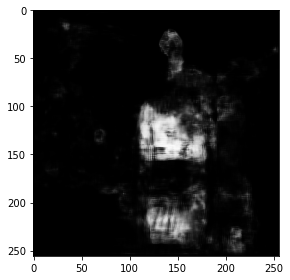

In [47]:
cap = cv2.VideoCapture(0)
try:
    time.sleep(5)
    #while(True):
    ret, frame = cap.read()
    img = cv2.resize(frame, (img_shape, img_shape)) / 255

    pred = model.predict(np.array([img]))[0]
    
    i = 10
    print(class_encoded[i][2][0])
    imshow(pred[:, :, i])
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
finally:    
    cap.release()
    cv2.destroyAllWindows()

In [16]:
cap.release()
cv2.destroyAllWindows()

In [20]:
cap = cv2.VideoCapture(0)

In [21]:
ret, frame = cap.read()

In [ ]:
def pred_img(path):
    img = imread(path)
    img = cv2.resize(img, (img_shape, img_shape)) / 255

    pred = model.predict(np.array([img]))[0]
    
    for i in range(32):
        mask = pred[:, :, i]
        print(np.sum(mask) / img_shape /img_shape)
        
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        
        plt.imshow(img)
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray", norm=None)
        
        plt.title(class_encoded[i][2])
        plt.show()
    return pred

In [ ]:
pred = pred_img('/home/rv/vJTMMZikU5k.jpg')